# Supervised Learning Using H2O


* Motivation:

The purpose of this assigment is to use the H2O ai model to build several supervised learning models. The goal here is to use the algorithms gbm and randomforest to build models wihtout having to deal with any feature engineering techniques. 

* Resources:
        
        *Dataset on Loan Deafaults.
        *H2O Algorithm
        
* Methods:
        
        *GBM and Random Forest Algorithms
        *Fine Tunning Hyperparameters.
        *Model Ensembeling
        
        
* Objective:

Using the Loand Deafaults dataset find the best model to predict loan defaults.

In [50]:
#initialize the H2O cluster.
import h2o
h2o.init(nthreads=-1,enable_assertions = False)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/ym/mys4fwjn1dl048388qwd1m080000gn/T/tmp8jrfvbaw
  JVM stdout: /var/folders/ym/mys4fwjn1dl048388qwd1m080000gn/T/tmp8jrfvbaw/h2o_luislosada_started_from_python.out
  JVM stderr: /var/folders/ym/mys4fwjn1dl048388qwd1m080000gn/T/tmp8jrfvbaw/h2o_luislosada_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_luislosada_1ha9m7
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
import os
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
os.chdir('/Users/luislosada/Columbia Drive/Anomaly Detection/Module 9')

In [52]:
#Load Data and Transform Variables
data = pd.read_csv("XYZloan_default_selected_vars.csv")
data.drop(columns=['Unnamed: 0','Unnamed: 0.1',"AP004"],inplace=True)
data['AP005'] = pd.to_datetime(data['AP005'])
is_weekend = [1 if datetime.datetime.weekday(day) > 5 else 0 for day in data['AP005']]
data.insert(loc=data.columns.get_loc('AP005')+1,column='is_weekend',value=is_weekend)


In [53]:
#View Proportion of NAs in the variables.
d_na = pd.DataFrame(data.isna().sum())
d_na['prop'] = d_na.iloc[:,0]/len(data)
d_na[d_na.iloc[:,0] > 0]


,0,prop
TD022,19598,0.244975
TD023,7663,0.095787
TD024,3694,0.046175
TD025,2550,0.031875
TD026,1846,0.023075
TD027,1697,0.021212
TD028,1636,0.020450
TD029,1630,0.020375
TD044,79997,0.999962
TD048,79999,0.999988


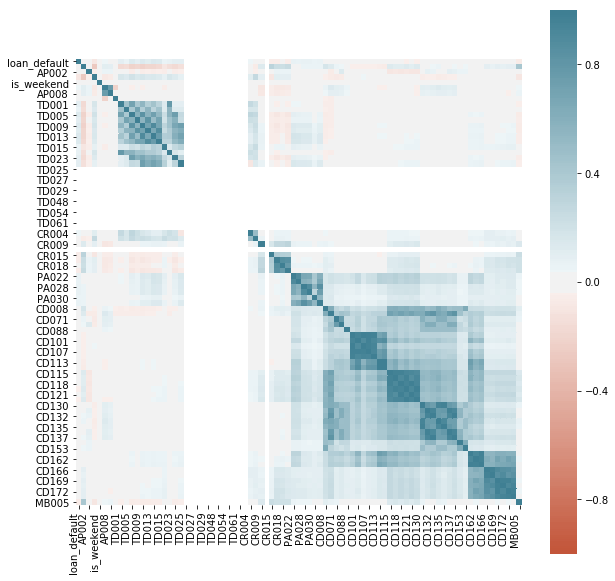

In [54]:
#Correlation Map
ax = plt.figure(figsize = (10,10))
corr = data.drop(columns = ['id']).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);


##### Preprocessing

It seems that although there are variables with lots of NAs (24% of the data for the TD022 variable) all variables will be useful for the model. High correlation might cause some multicollinearity but the algorithm should resolve these issues. 

Lets now create a train and a test set and transform the dataframes into a H2O object that can be used by the H2O algorithms.

In [55]:
train, test = train_test_split(
     data, test_size=0.30, random_state=42)

train = train.reset_index()

train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)
train.dtypes


index                    int64
id                       int64
loan_default             int64
AP001                    int64
AP002                    int64
AP003                    int64
AP005           datetime64[ns]
is_weekend               int64
AP006                   object
AP007                    int64
AP008                    int64
AP009                    int64
TD001                    int64
TD002                    int64
TD005                    int64
TD006                    int64
TD009                    int64
TD010                    int64
TD013                    int64
TD014                    int64
TD015                    int64
TD022                  float64
TD023                  float64
TD024                  float64
TD025                  float64
TD026                  float64
TD027                  float64
TD028                  float64
TD029                  float64
TD044                  float64
                     ...      
CD107                  float64
CD108   

##### Creating the feature and target variables

In order to select the columns that will become the predictors and the target variable, I will create a list of all the names of the columns that correpond to each category. The ID variable will be dropped since it should not have any predictive power. 

In [56]:
features = list(data.columns)
target = "loan_default"
features.remove("loan_default")
features.remove("id")



In [57]:
train['loan_default'].value_counts(normalize=True)

0    0.806786
1    0.193214
Name: loan_default, dtype: float64

In [58]:
test['loan_default'].value_counts(normalize=True)

0    0.8055
1    0.1945
Name: loan_default, dtype: float64

Seems that the test and train set share the same distribution of the target variable. Lets now move on to transforming the target variable to a factor so that the model can interpret this as a classification problem.

In [59]:
train_hex[target] = train_hex[target].asfactor()
test_hex[target] = test_hex[target].asfactor()

### Random Forest

First model to build is a random forest model. The idea is to train the model on pretty standard hyperparameters using most of the dafault states. The variable importance measurement will tell us how to deal with the variables afterwards and what to eliminate or add.

In [60]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        distribution="bernoulli",
        nfolds=10,
        fold_assignment="Modulo",
        keep_cross_validation_predictions=True,
        seed=1234,
        stopping_metric = "AUC")
rf_v1.train(features,target,training_frame=train_hex,validation_frame = test_hex)


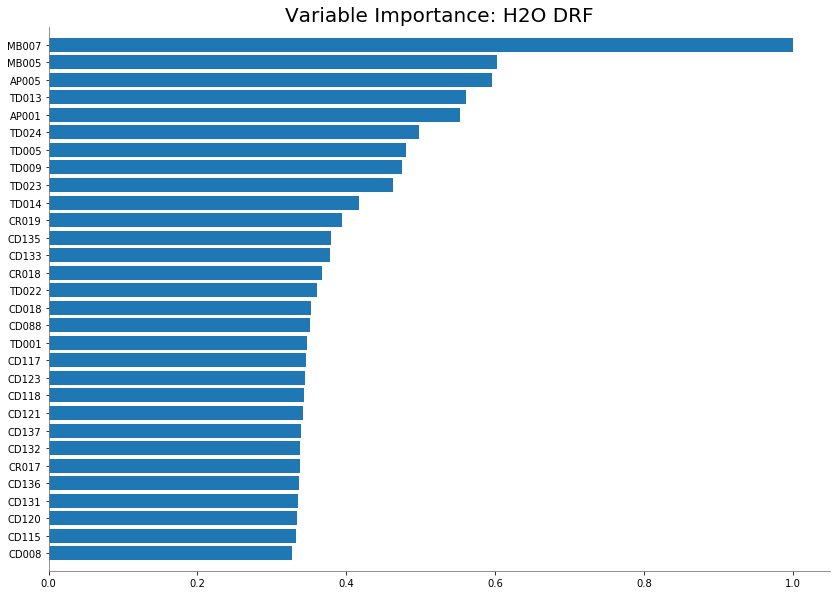

In [61]:
rf_v1.varimp_plot(30)

The MB007 Categorical variable seems to have the most importance. This probably means that the model is splitting the nodes based on these variables rather than on the other numerical variables. Lets work with this to normalize this aspect.

In [62]:
rf_v1.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17135179002087494: 


,,0,1,Error,Rate
0,0,2281.0,2269.0,0.4987,(2269.0/4550.0)
1,1,359.0,691.0,0.3419,(359.0/1050.0)
2,Total,2640.0,2960.0,0.4693,(2628.0/5600.0)


In [63]:
rf_v1.auc()

0.5990249084249084

##### Results

Confusion metric shows a pretty high error rate and very high specificity and recall. The AUC however seems to show some positive results. Lets look at a gains table and see if the model is producing actionable results.

In [64]:
rf_v1.gains_lift()


Gains/Lift Table: Avg response rate: 18.75 %, avg score: 19.77 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010000,0.545476,1.333333,1.333333,0.250000,0.613811,0.250000,0.613811,0.013333,0.013333,33.333333,33.333333
1,,2,0.026607,0.500000,1.777778,1.610738,0.333333,0.513435,0.302013,0.551161,0.029524,0.042857,77.777778,61.073826
2,,3,0.030000,0.478372,1.122807,1.555556,0.210526,0.489508,0.291667,0.544188,0.003810,0.046667,12.280702,55.555556
3,,4,0.040357,0.454545,1.563218,1.557522,0.293103,0.466406,0.292035,0.524226,0.016190,0.062857,56.321839,55.752212
4,,5,0.050000,0.437399,1.481481,1.542857,0.277778,0.443535,0.289286,0.508664,0.014286,0.077143,48.148148,54.285714
5,,6,0.100536,0.375000,1.601885,1.572528,0.300353,0.400703,0.294849,0.454396,0.080952,0.158095,60.188457,57.252812
6,,7,0.158393,0.333333,1.152263,1.419015,0.216049,0.349623,0.266065,0.416125,0.066667,0.224762,15.226337,41.901541
7,,8,0.200000,0.301602,1.442060,1.423810,0.270386,0.315175,0.266964,0.395124,0.060000,0.284762,44.206009,42.380952
8,,9,0.300000,0.251308,1.209524,1.352381,0.226786,0.275867,0.253571,0.355372,0.120952,0.405714,20.952381,35.238095
9,,10,0.400000,0.212943,1.171429,1.307143,0.219643,0.232372,0.245089,0.324622,0.117143,0.522857,17.142857,30.714286


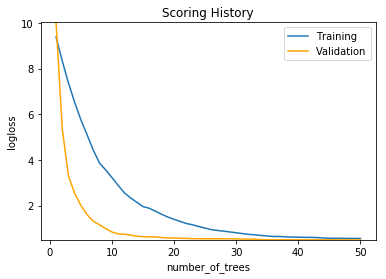

In [65]:
rf_v1.plot()

##### Lift

The model shows a very healthy lift that shows that the model is producing better reults than just picking values randomly. One of the things that could be affecting model performance is overfitting, so lets how its affecting this model. 

##### Overfitting

The plot shows us that the model is not overfitting the data and is actually fitting the validation set just as well as it fits the train set. This is great news but we could tweak the model a bit further in favor of some more accuracy.

##### Cardinality

High cardinality, or too many unique values, can cause trees to use that variable to split the nodes a lot more than it should and thus give categorical variables more importance than what it should have. To treat for this lets standarize the categorical variables by using a type of encoding that reduces the importance of the variable without affecting the model's perfomance.

In [66]:
def VarimpByCardinality(data, cardinality, response):
    
    random_cat = h2o.create_frame(rows = data.nrow, cols = 1, 
                                  binary_fraction = 0, time_fraction = 0, integer_fraction = 0, string_fraction = 0,
                                  categorical_fraction = 1, factors = cardinality, 
                                  has_response = False, seed = 1234
                             )
    
    data = data.cbind(random_cat)
    
    train, test = data.split_frame(seed = 1234)
    
    predictors = list(set(train.col_names) - set([response]))
    
    gbm = H2OGradientBoostingEstimator(model_id = "gbm.hex",
                                       score_tree_interval = 10, ntrees = 500,
                                       ## early stopping once the validation AUC doesn't improve by at least 0.1% 
                                       ## for 5 consecutive scoring events
                                       stopping_rounds = 5, stopping_metric = "AUC", stopping_tolerance = 0.001
                                      )
    
    gbm.train(x = predictors, y = response, training_frame = train, validation_frame = test)
    
    varimp = gbm.varimp(use_pandas = True)
    random_varimp = varimp[varimp["variable"] == "C1"]["relative_importance"].min()
    
    return random_varimp

cardinalities = [2, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
varimp = []
h2o.no_progress()

for i in cardinalities:
    varimp = varimp + [VarimpByCardinality(train_hex, i, "loan_default")]

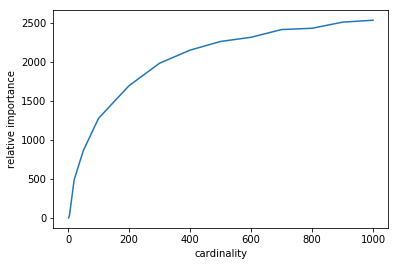

In [67]:
plt.plot(cardinalities, varimp)
plt.xlabel('cardinality') 
plt.ylabel('relative importance')
plt.show()

##### Grid Search for Categorical Encoding 

It does seem then that as cardinality increases relative importance of the variable increases exponentially. A way to deal with this is by iterating over several models that use different types of encoding for categorical variables until the best model is found. Lets set this up

In [68]:
from h2o.grid import H2OGridSearch

hyper_params = hyper_params = {
    ## search for the best categorical encoding
    'categorical_encoding':["Enum", "OneHotExplicit", "Binary", "Eigen", "LabelEncoder", 
                            "SortByResponse", "EnumLimited"],
    
    ## search a large space of the number of bins for split-finding for categorical columns
    'nbins_cats':[16, 32, 64, 128]
}

search_criteria = {
    ## Random grid search
    'strategy':"RandomDiscrete",      
    
    ## limit the runtime to 60 minutes
    'max_runtime_secs':3600,         
    
    ## build no more than 100 models
    'max_models':100,                  
  
    ## random number generator seed to make sampling of parameter combinations reproducible
    'seed':1234,                        
  
    # early stopping once the leaderboard of the top 5 models is converged to 0.1% relative difference
    'stopping_rounds':5, 'stopping_metric':"AUC", 'stopping_tolerance':1e-3
}

In [69]:
rf_grid = H2OGridSearch(grid_id="grid.hex", hyper_params=hyper_params, 
                         model=rf_v1, search_criteria=search_criteria)

In [70]:
rf_grid.train(x = features, y = target, training_frame=train_hex, validation_frame=test_hex)

Errors/Warnings building gridsearch model

Hyper-parameter: categorical_encoding, LabelEncoder
Hyper-parameter: nbins_cats, 16
failure_details: DistributedException from /127.0.0.1:54321: 'For input string: "WEB"'
failure_stack_traces: DistributedException from /127.0.0.1:54321: 'For input string: "WEB"', caused by java.lang.NumberFormatException: For input string: "WEB"
	at water.MRTask.getResult(MRTask.java:479)
	at water.MRTask.getResult(MRTask.java:487)
	at water.MRTask.doAll(MRTask.java:391)
	at water.MRTask.doAll(MRTask.java:378)
	at water.MRTask.doAll(MRTask.java:377)
	at water.util.VecUtils.categoricalToInt(VecUtils.java:261)
	at water.util.VecUtils.toNumericVec(VecUtils.java:170)
	at water.fvec.Vec.toNumericVec(Vec.java:1314)
	at water.util.FrameUtils$CategoricalLabelEncoder$CategoricalLabelEncoderDriver.compute2(FrameUtils.java:654)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1423)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.do

In [72]:
sorted_grid = rf_grid.get_grid(sort_by="auc", decreasing=True)
sorted_grid


     categorical_encoding nbins_cats          model_ids                 auc
0          SortByResponse         32  grid.hex_model_24  0.6325301936159079
1                   Eigen        128   grid.hex_model_9  0.6321109366823652
2                   Eigen         32  grid.hex_model_17  0.6321109366823652
3                   Eigen         64  grid.hex_model_13  0.6321109366823652
4                   Eigen         16  grid.hex_model_22  0.6321109366823652
5                    Enum         32  grid.hex_model_25  0.6303138670852956
6          SortByResponse         16  grid.hex_model_28  0.6303013082155939
7                    Enum         16   grid.hex_model_7  0.6302281527995813
8          OneHotExplicit         16  grid.hex_model_21   0.630138775510204
9          OneHotExplicit         64   grid.hex_model_8   0.630138775510204
10         OneHotExplicit        128  grid.hex_model_19   0.630138775510204
11         OneHotExplicit         32  grid.hex_model_23   0.630138775510204
12          

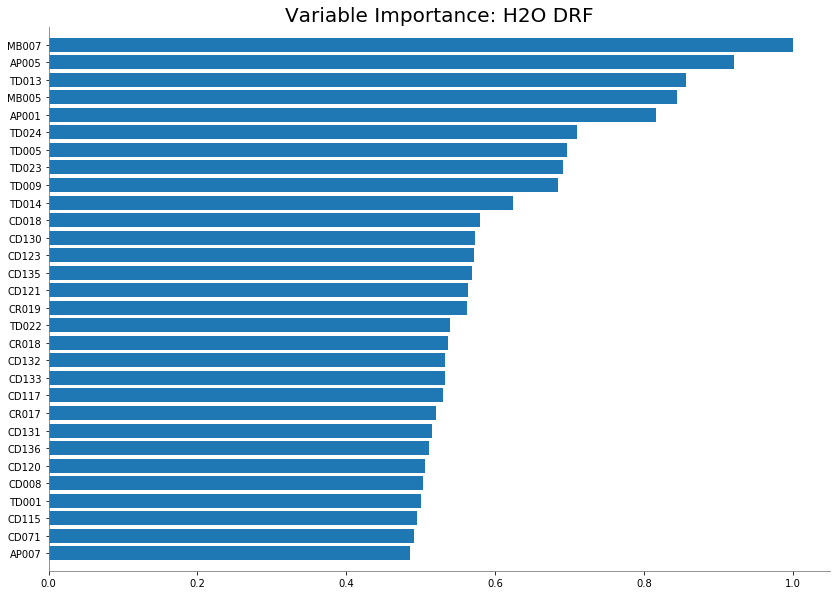

In [73]:
best_model = sorted_grid.models[0]
best_model.varimp_plot(30)

In [74]:
best_model.gains_lift()


Gains/Lift Table: Avg response rate: 18.75 %, avg score: 20.04 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010714,0.571429,1.422222,1.422222,0.266667,0.621499,0.266667,0.621499,0.015238,0.015238,42.222222,42.222222
1,,2,0.020000,0.508057,1.846154,1.619048,0.346154,0.534027,0.303571,0.580887,0.017143,0.032381,84.615385,61.904762
2,,3,0.031607,0.473684,1.805128,1.687382,0.338462,0.490856,0.316384,0.547825,0.020952,0.053333,80.512821,68.738230
3,,4,0.040179,0.454545,1.555556,1.659259,0.291667,0.462483,0.311111,0.529619,0.013333,0.066667,55.555556,65.925926
4,,5,0.050000,0.435588,1.551515,1.638095,0.290909,0.443249,0.307143,0.512653,0.015238,0.081905,55.151515,63.809524
5,,6,0.101786,0.375000,1.544828,1.590643,0.289655,0.402582,0.298246,0.456652,0.080000,0.161905,54.482759,59.064327
6,,7,0.164107,0.333333,1.574021,1.584331,0.295129,0.349232,0.297062,0.415858,0.098095,0.260000,57.402101,58.433079
7,,8,0.200000,0.307452,1.008292,1.480952,0.189055,0.316974,0.277679,0.398112,0.036190,0.296190,0.829187,48.095238
8,,9,0.300000,0.257576,1.266667,1.409524,0.237500,0.281102,0.264286,0.359108,0.126667,0.422857,26.666667,40.952381
9,,10,0.400000,0.214286,1.047619,1.319048,0.196429,0.235955,0.247321,0.328320,0.104762,0.527619,4.761905,31.904762


In [75]:
best_model.auc()

0.6118205128205129

In [76]:
best_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15244802954051817: 


,,0,1,Error,Rate
0,0,1972.0,2578.0,0.5666,(2578.0/4550.0)
1,1,288.0,762.0,0.2743,(288.0/1050.0)
2,Total,2260.0,3340.0,0.5118,(2866.0/5600.0)


Final results of the model show some improvement in the AUC measuremnt but a lower accuracy. Lets look into other models then to see if we can improve results.

### GBM

Gradient Booster Machines use gradient descent to adjust the model. The goal is to create a formula capable of repdocuing the model but that reduces the gadient descent. A big caveat of GBM is that it tends to overfit on the train set. Lets look at a simple gbm then and then try to tune it to find the best model.

In [27]:
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      nfolds=10,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1234)
my_gbm.train(x=features, y=target, training_frame=train_hex,validation_frame = test_hex)

In [28]:
my_gbm.auc()

0.9127181580324437

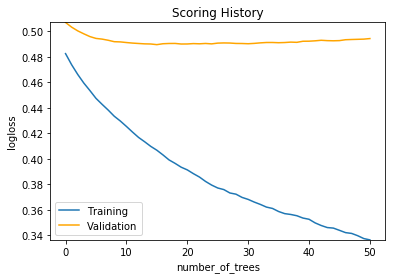

In [29]:
my_gbm.plot()

As expected, this model is clearly overfitting on the train set. A way to solve for this is to use grid search again with different parameters to tune the model.

In [30]:
my_gbm.gains_lift()


Gains/Lift Table: Avg response rate: 18.75 %, avg score: 18.79 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.654977,5.333333,5.333333,1.000000,0.714773,1.000000,0.714773,0.053333,0.053333,433.333333,433.333333
1,,2,0.02,0.591277,5.333333,5.333333,1.000000,0.621362,1.000000,0.668067,0.053333,0.106667,433.333333,433.333333
2,,3,0.03,0.541387,5.333333,5.333333,1.000000,0.563550,1.000000,0.633228,0.053333,0.160000,433.333333,433.333333
3,,4,0.04,0.503626,5.333333,5.333333,1.000000,0.521672,1.000000,0.605339,0.053333,0.213333,433.333333,433.333333
4,,5,0.05,0.474721,4.952381,5.257143,0.928571,0.488622,0.985714,0.581996,0.049524,0.262857,395.238095,425.714286
5,,6,0.10,0.360156,4.476190,4.866667,0.839286,0.413008,0.912500,0.497502,0.223810,0.486667,347.619048,386.666667
6,,7,0.15,0.298124,2.876190,4.203175,0.539286,0.324846,0.788095,0.439950,0.143810,0.630476,187.619048,320.317460
7,,8,0.20,0.257752,1.790476,3.600000,0.335714,0.277004,0.675000,0.399213,0.089524,0.720000,79.047619,260.000000
8,,9,0.30,0.207969,1.057143,2.752381,0.198214,0.230301,0.516071,0.342909,0.105714,0.825714,5.714286,175.238095
9,,10,0.40,0.172907,0.638095,2.223810,0.119643,0.189772,0.416964,0.304625,0.063810,0.889524,-36.190476,122.380952


In [31]:
my_gbm.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27915708118259114: 


,,0,1,Error,Rate
0,0,4298.0,252.0,0.0554,(252.0/4550.0)
1,1,334.0,716.0,0.3181,(334.0/1050.0)
2,Total,4632.0,968.0,0.1046,(586.0/5600.0)


#### Fine Tunning

Some of the most important parameters for gbm are learning rate, number of trees and max depth. Lets fine tune the model along those parameters.
The gird search parameter can also use several sample rates to adjust results so lets look at sample rate and column sample rates to enhance the model.


In [32]:
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0],
              'ntrees': [10, 100, 500]}

In [33]:
gbm_grid = H2OGridSearch(model=my_gbm,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)

In [34]:
gbm_grid.train(x = features, y = target, training_frame=train_hex, validation_frame=test_hex)

In [35]:
gbm_sorted_grid = gbm_grid.get_grid(sort_by="auc", decreasing=True)
gbm_sorted_grid

       col_sample_rate learn_rate max_depth ntrees sample_rate  \
0                  0.2       0.01         3    500         0.8   
1                  0.2       0.01         3    500         1.0   
2                  0.5       0.01         3    500         0.8   
3                  0.2        0.1         3    100         1.0   
4                  0.2       0.01         5    500         0.8   
5                  0.2       0.01         5    500         1.0   
6                  0.2        0.1         3    100         0.8   
7                  1.0       0.01         3    500         0.8   
8                  0.5       0.01         3    500         1.0   
9                  1.0       0.01         5    500         0.8   
10                 0.2       0.01         5    100         0.8   
11                 0.5       0.01         5    500         0.8   
12                 1.0        0.1         3    100         0.8   
13                 0.5        0.1         3    100         1.0   
14        

In [36]:
best_gbm = gbm_sorted_grid.models[0]

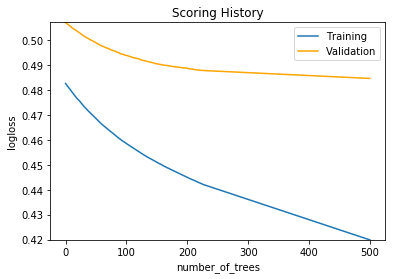

In [37]:
best_gbm.plot()

Much better results and way less overfitting. Now lets look at the performance metrics of the model.

In [38]:
best_gbm.gains_lift()


Gains/Lift Table: Avg response rate: 18.75 %, avg score: 18.75 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.450173,4.857143,4.857143,0.910714,0.511489,0.910714,0.511489,0.048571,0.048571,385.714286,385.714286
1,,2,0.02,0.411069,4.380952,4.619048,0.821429,0.428720,0.866071,0.470104,0.043810,0.092381,338.095238,361.904762
2,,3,0.03,0.381321,2.761905,4.000000,0.517857,0.394994,0.750000,0.445068,0.027619,0.120000,176.190476,300.000000
3,,4,0.04,0.362184,2.857143,3.714286,0.535714,0.371942,0.696429,0.426786,0.028571,0.148571,185.714286,271.428571
4,,5,0.05,0.349563,3.523810,3.676190,0.660714,0.355391,0.689286,0.412507,0.035238,0.183810,252.380952,267.619048
5,,6,0.10,0.303170,2.400000,3.038095,0.450000,0.325832,0.569643,0.369170,0.120000,0.303810,140.000000,203.809524
6,,7,0.15,0.274065,2.209524,2.761905,0.414286,0.288582,0.517857,0.342307,0.110476,0.414286,120.952381,176.190476
7,,8,0.20,0.250316,1.695238,2.495238,0.317857,0.262093,0.467857,0.322253,0.084762,0.499048,69.523810,149.523810
8,,9,0.30,0.215067,1.247619,2.079365,0.233929,0.231993,0.389881,0.292167,0.124762,0.623810,24.761905,107.936508
9,,10,0.40,0.189613,1.000000,1.809524,0.187500,0.201916,0.339286,0.269604,0.100000,0.723810,0.000000,80.952381


In [39]:
best_gbm.auc()

0.777698063840921

In [40]:
best_gbm.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23607632751987515: 


,,0,1,Error,Rate
0,0,3797.0,753.0,0.1655,(753.0/4550.0)
1,1,463.0,587.0,0.441,(463.0/1050.0)
2,Total,4260.0,1340.0,0.2171,(1216.0/5600.0)


##### Results
Performance on the train set goes down in exchange for better fitting of the test set.

## Ensemble Methods

Since GBM is performing so well on the train set and Random Forest is able to produce more reasonable results on the Test Set with almsot no overfitting lets combine both models to create an ensembled model. 



In [41]:
ensemble = H2OStackedEnsembleEstimator(model_id="n_ensemble",
                                       base_models=[best_gbm,best_model])
ensemble.train(x=features, y=target, training_frame=train_hex)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test_hex)

# Compare to base learner performance on the test set
perf_gbm_test = best_gbm.model_performance(test_hex)
perf_rf_test = best_model.model_performance(test_hex)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test_hex)

Best Base-learner Test AUC:  0.6527283897852335
Ensemble Test AUC:  0.6530067314884069


/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [HTC, IPHONE3, IVVI, KINGSUN, SONY, ZUK]
  warnings.warn(w)


In [42]:
h2o.shutdown()

[WARNING] in <ipython-input-42-1edf85295eae> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_b43c closed.


In [43]:
ensemble.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2410797847777158: 


,,0,1,Error,Rate
0,0,4204.0,346.0,0.076,(346.0/4550.0)
1,1,185.0,865.0,0.1762,(185.0/1050.0)
2,Total,4389.0,1211.0,0.0948,(531.0/5600.0)


In [44]:
ensemble.auc()

0.9598192569335428

In [48]:
ensemble.gains_lift()


Gains/Lift Table: Avg response rate: 18.75 %, avg score: 19.16 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.608955,5.333333,5.333333,1.000000,0.683171,1.000000,0.683171,0.053333,0.053333,433.333333,433.333333
1,,2,0.02,0.535369,5.142857,5.238095,0.964286,0.576538,0.982143,0.629855,0.051429,0.104762,414.285714,423.809524
2,,3,0.03,0.496845,5.333333,5.269841,1.000000,0.516154,0.988095,0.591955,0.053333,0.158095,433.333333,426.984127
3,,4,0.04,0.464886,5.238095,5.261905,0.982143,0.479625,0.986607,0.563872,0.052381,0.210476,423.809524,426.190476
4,,5,0.05,0.442260,5.047619,5.219048,0.946429,0.452509,0.978571,0.541600,0.050476,0.260952,404.761905,421.904762
5,,6,0.10,0.352740,4.533333,4.876190,0.850000,0.393070,0.914286,0.467335,0.226667,0.487619,353.333333,387.619048
6,,7,0.15,0.290386,3.314286,4.355556,0.621429,0.316641,0.816667,0.417103,0.165714,0.653333,231.428571,335.555556
7,,8,0.20,0.251271,2.647619,3.928571,0.496429,0.269963,0.736607,0.380318,0.132381,0.785714,164.761905,292.857143
8,,9,0.30,0.200738,1.466667,3.107937,0.275000,0.223667,0.582738,0.328101,0.146667,0.932381,46.666667,210.793651
9,,10,0.40,0.170232,0.523810,2.461905,0.098214,0.184134,0.461607,0.292109,0.052381,0.984762,-47.619048,146.190476


## Final Results

A model that fits the data better is created by ensembling both models while producing a big lift. The results show that the combination of both these models produces the best results.